# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
3. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
4. [Syntethic VS Real](#Quality-assessment)
5. [Conclusion](#Conclusion)

## Libraries

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr, entropy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [2]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [5]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

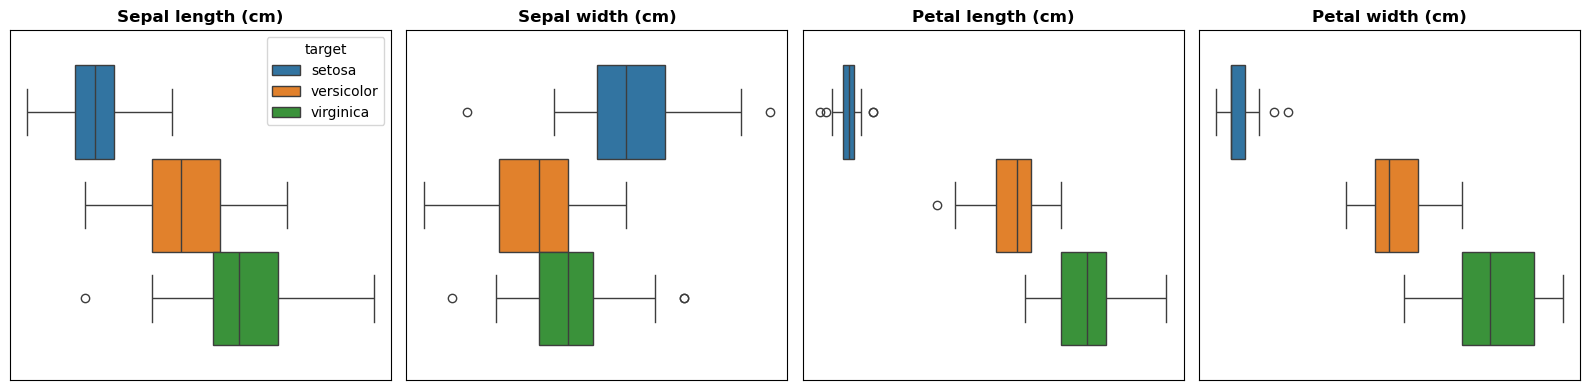

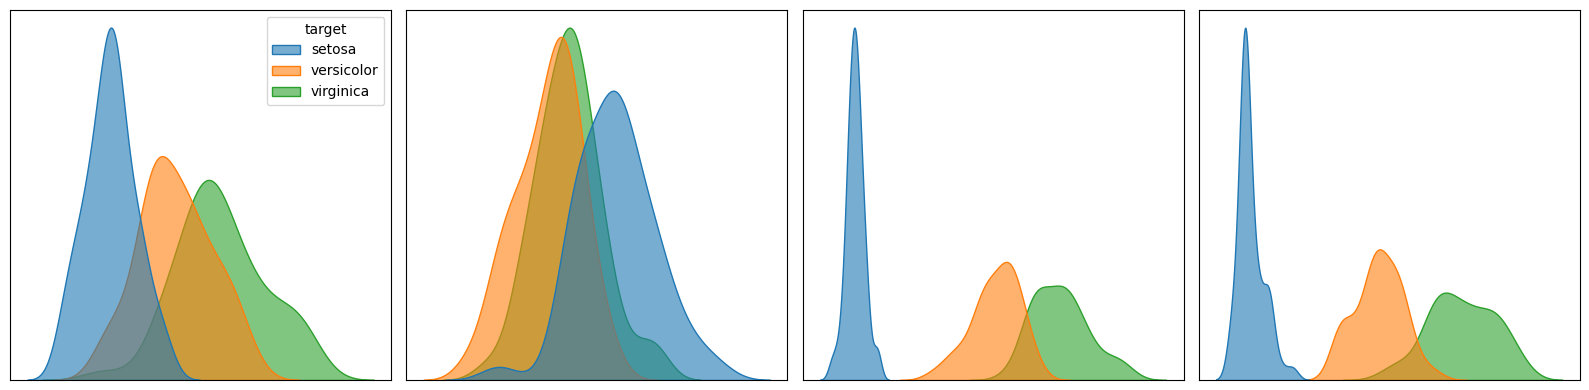

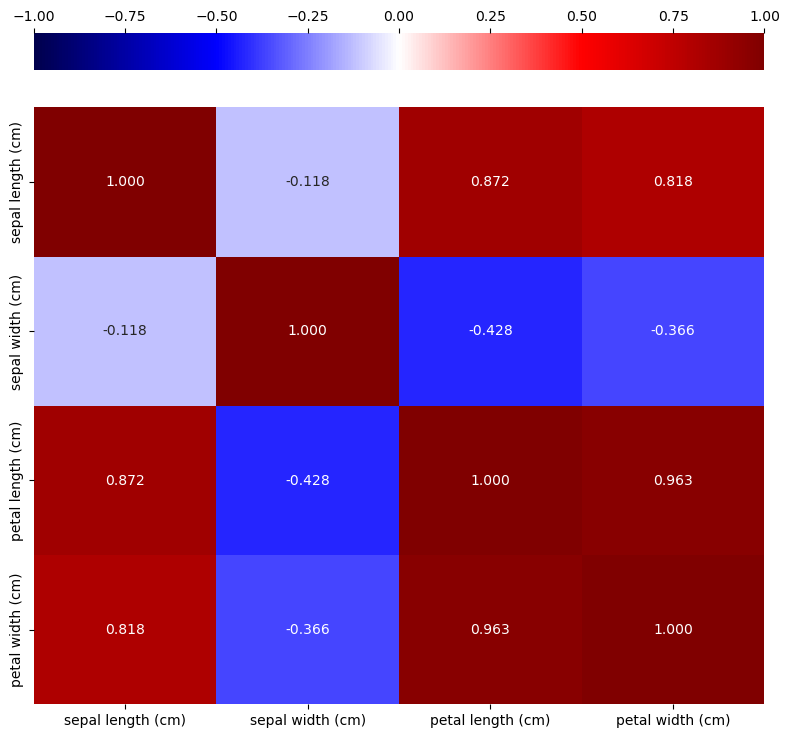

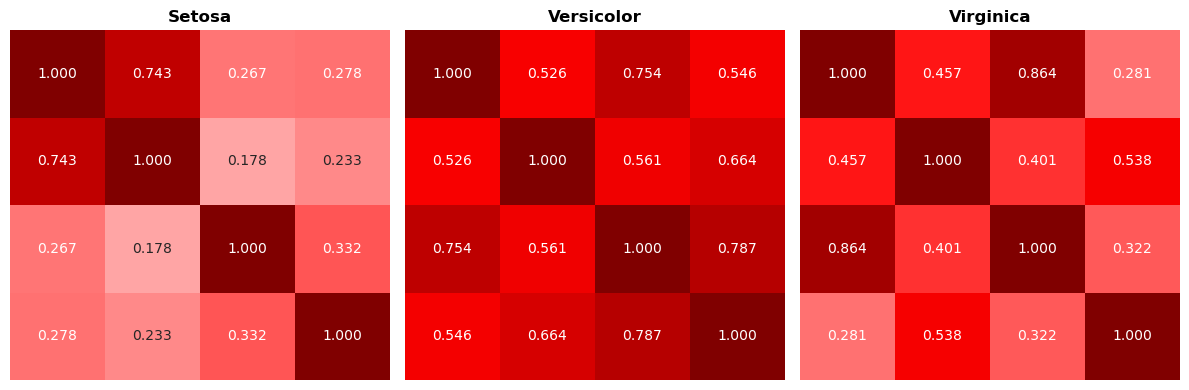

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.700938,3.110783,2.083746,0.612099,setosa
1,5.137784,3.598630,3.839143,-1.177103,setosa
2,4.570401,2.249941,0.499811,-1.437989,setosa
3,4.454552,2.955025,2.706664,0.437538,setosa
4,5.113479,4.216757,1.513889,-0.183703,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [8]:
utils.describe_data(real_iris, 'target', df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.119      5.905   
     sepal width (cm)   3.428      2.770     2.974     3.399      2.901   
     petal length (cm)  1.462      4.260     5.552     1.518      4.341   
     petal width (cm)   0.246      1.326     2.026    -0.023      1.339   
STD  sepal length (cm)  0.352      0.516     0.636     0.875      1.093   
     sepal width (cm)   0.379      0.314     0.322     1.087      1.008   
     petal length (cm)  0.174      0.470     0.552     0.999      1.206   
     petal width (cm)   0.105      0.198     0.275     1.041      1.269   
MIN  sepal length (cm)  4.300      4.900     4.900     3.208      3.770   
     sepal width (cm)   2.300      2.000     2.200     1.260      0.219   
     petal length (cm)  1.000      3.000     4.500    -0.275      1.468   
     petal width (cm)   0.100      1.000     1.400    -2.503     -1.982   
MAX  sepal length (cm)  5.800      7.000     7.900     6.946      8.162   
     sepal width (cm)   4.400      3.400     3.800     5.981      5.228   
     petal length (cm)  1.900      5.100     6.900     3.839      7.306   
     petal width (cm)   0.600      1.800     2.500     1.801      3.597   
SKEW sepal length (cm)  0.116      0.102     0.114    -0.229      0.176   
     sepal width (cm)   0.040     -0.352     0.355     0.103      0.185   
     petal length (cm)  0.103     -0.588     0.533     0.312     -0.011   
     petal width (cm)   1.216     -0.030    -0.126    -0.089     -0.207   
KURT sepal length (cm) -0.346     -0.599    -0.088    -0.393     -0.584   
     sepal width (cm)   0.744     -0.448     0.520    -0.539      0.514   
     petal length (cm)  0.805     -0.074    -0.256    -0.565      0.149   
     petal width (cm)   1.434     -0.488    -0.661    -0.795     -0.412   
IQR  sepal length (cm)  0.400      0.700     0.675     1.162      1.528   
     sepal width (cm)   0.475      0.475     0.375     1.733      0.766   
     petal length (cm)  0.175      0.600     0.775     1.348      1.565   
     petal width (cm)   0.100      0.300     0.500     1.559      1.847   

                                  
                       virginica  
MEAN sepal length (cm)     6.584  
     sepal width (cm)      2.795  
     petal length (cm)     5.473  
     petal width (cm)      2.103  
STD  sepal length (cm)     1.105  
     sepal width (cm)      0.903  
     petal length (cm)     1.041  
     petal width (cm)      1.069  
MIN  sepal length (cm)     4.791  
     sepal width (cm)      0.611  
     petal length (cm)     3.657  
     petal width (cm)     -0.147  
MAX  sepal length (cm)     9.357  
     sepal width (cm)      4.760  
     petal length (cm)     7.821  
     petal width (cm)      5.516  
SKEW sepal length (cm)     0.762  
     sepal width (cm)     -0.001  
     petal length (cm)     0.372  
     petal width (cm)      0.788  
KURT sepal length (cm)     0.004  
     sepal width (cm)     -0.417  
     petal length (cm)    -0.815  
     petal width (cm)      1.275  
IQR  sepal length (cm)     1.055  
     sepal width (cm)      1.282  
     petal length (cm)     1.587  
     petal width (cm)      1.415

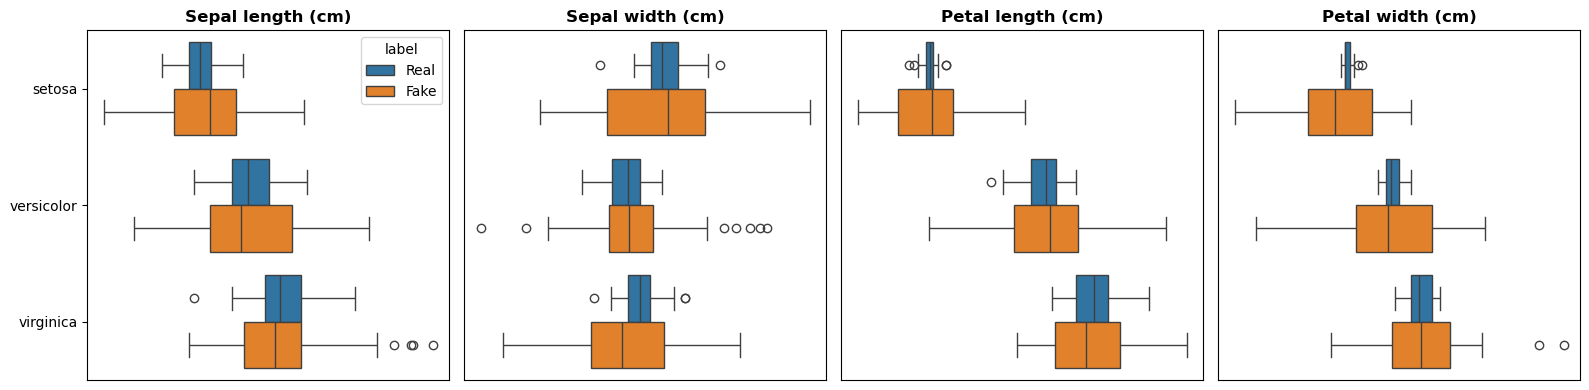

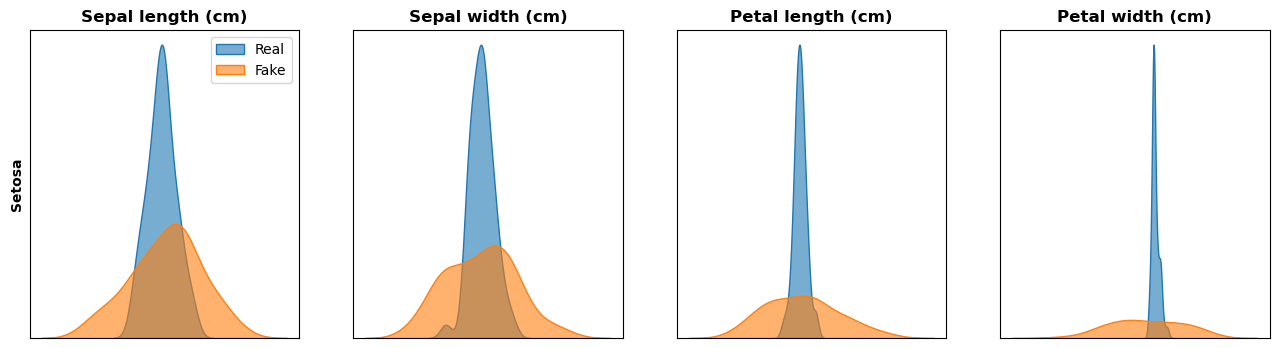

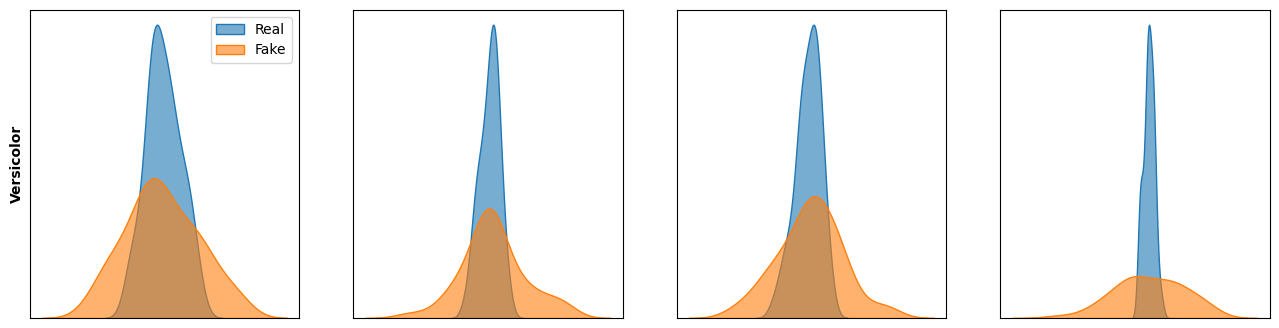

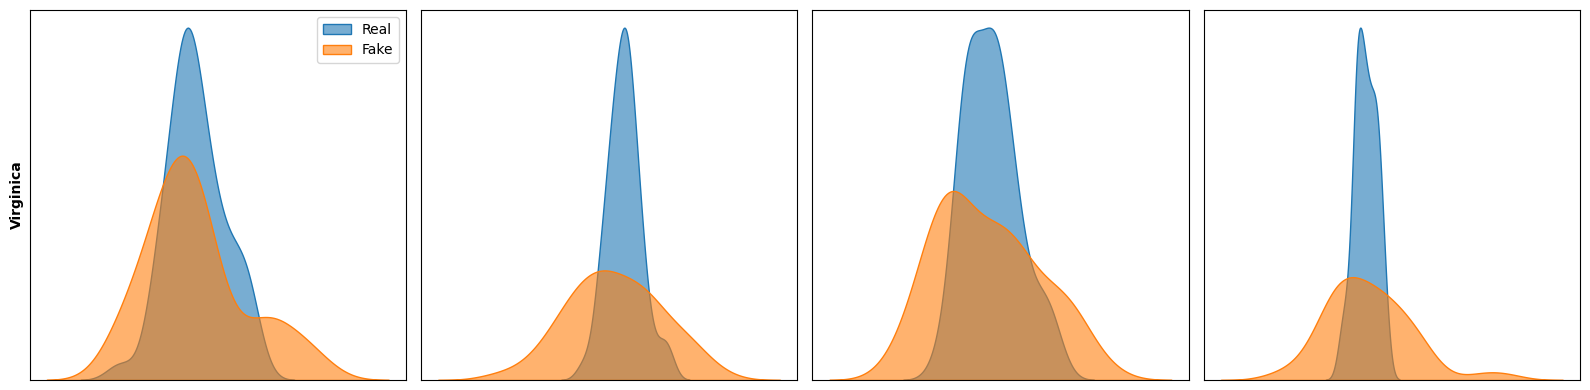

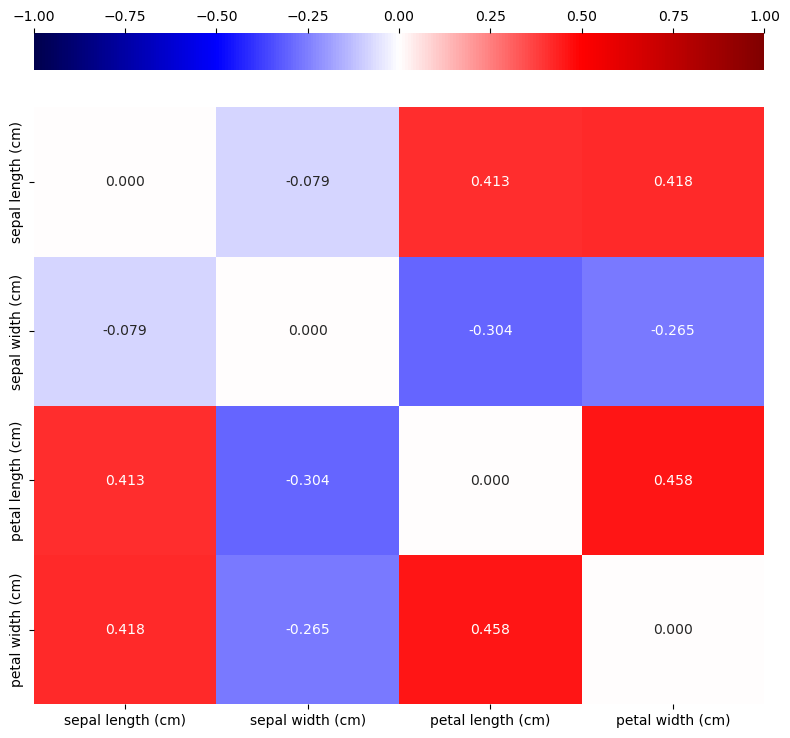

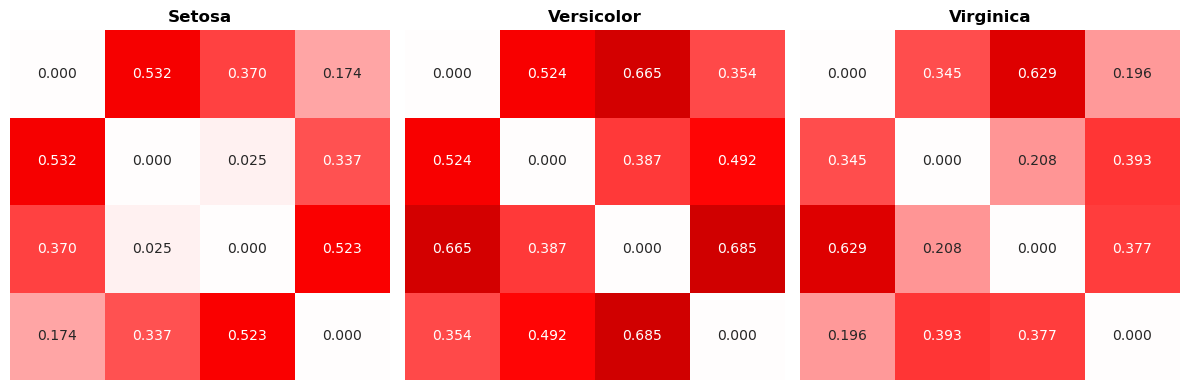

In [9]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. Two different architectures will be used to achieve this goal: the Variational Auto Encoder **(VAE)** and the Generative Adversarial Network **(GAN)**, and the one that will show the best performance for the same task complexity and resources will be selected.

## GAN vs VAE

Both valid, the two approaches show different challenges and advantages:

1. **Variational Auto Encoder**:

Pros:
- Easy to train
- We can look inside the neaural network "Black Box"

Cons:

- Less coverage of variability
- Assumption of data normality

2. **Generative Adversarial Network**:

Pros:
- More realistic generated data
- Flexibility with respect to actual data distributions

Cons:
- Hard to train (model collapse, lot of resources, lot of data)
- Lower interpretability

The performance of the two architectures will be analyzed using them in as simple a version as possible. The next step will then be to prepare the data for modeling.

In [10]:
std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

ohe = OneHotEncoder(sparse_output = False)
y_ohe = ohe.fit_transform(y.reshape(-1,1))

Preparing Torch Dataset and Dataloader

In [11]:
class IrisDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_vae_dataset = IrisDataset(X_scld, y_ohe)
real_vae_dataloader = DataLoader(real_vae_dataset, batch_size = 32, shuffle = True)

real_gan_dataset = IrisDataset(X_scld, y)
real_gan_dataloader = DataLoader(real_gan_dataset, batch_size = 32, shuffle = True)

for dataloader in [real_vae_dataloader, real_gan_dataloader]:
    for batch in dataloader:
        print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
        break

Data shape: torch.Size([32, 4]), labels shape: torch.Size([32, 3])
Data shape: torch.Size([32, 4]), labels shape: torch.Size([32])


Let's build baseline models, starting with the Conditional VAE

In [19]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Tanh()  # Output compreso tra 0 e 1
        )
        
    def encode(self, x, c):
        x_cond = torch.cat([x, c], dim=1)
        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar
    
    
vae = ConditionalVAE(input_dim = 4, latent_dim = 2, condition_dim = 3)

for batch in real_vae_dataloader:
    batch = batch
    break
    
vae_out = vae(batch[0], batch[1])
for out in vae_out:
    print(f'Shape: {out.shape}')

Shape: torch.Size([32, 4])
Shape: torch.Size([32, 2])
Shape: torch.Size([32, 2])


Now let's build the GANs net.

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 4)
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
    
gen = Generator(input_dim = 2, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

for batch in real_gan_dataloader:
    batch = batch
    break
    
print(f'Generator output shape: {gen(torch.randn(32, 2), batch[1]).shape}')
print(f'Discriminator output shape: {disc(batch[0], batch[1]).shape}')

Generator output shape: torch.Size([32, 4])
Discriminator output shape: torch.Size([32, 1])


Let's check models' size in parameters.

In [14]:
print(f'VAE has {sum(p.numel() for p in vae.parameters())} parameters')
print(f'Gen has {sum(p.numel() for p in gen.parameters())} parameters')

VAE has 1624 parameters
Gen has 797 parameters


In [27]:
def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    
    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div /= original.size(0)  # Media per batch

    # Loss totale
    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div


In [28]:
out, mu, logvar = vae(batch[0], batch[1])

In [29]:
vae_loss(out, batch[0], mu, logvar)

AttributeError: module 'torch.functional' has no attribute 'mse_loss'

In [ ]:
F.